## **Задание 1:**
В ноутбуке 001 представлена реализация HOG дескриптора, не инвариантного к повороту изображений. </br>
Задание: модифицировать процедуру построения дескриптора таким образом, чтобы добиться инвариантности относительно поворота изображений, сделать демонстрацию на нескольких изображениях с явным подсчётом l1, l2. Результаты оформить в виде ноутбука (Collab). </br>

In [ ]:
!pip install -q opencv-python==4.8.0.76

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cityblock

Реализация HOG дескриптора, не инвариантного к повороту изображений:

In [ ]:
def hog(img, mode = "stats"):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)

    bin_n = 16
    bin = np.int32(bin_n * ang / (2 * np.pi))

    bin_cells = []
    mag_cells = []

    cellx = celly = 8

    for i in range(0, int(img.shape[0] / celly)):
        for j in range(0, int(img.shape[1] / cellx)):
            temp = bin[i * celly : i * celly + celly, j * cellx : j * cellx + cellx] # берем конкретное окно
            values, counts = np.unique(temp.ravel(), return_counts=True) # считаем кол-во значений

            dict_v_c = dict(zip(values, counts))
            dict_c_v = dict(zip(counts, values))

            norm_coef = counts.max()

            if mode == "stats":
                temp_answer = []

                for k in range(bin_n):
                    if k in dict_v_c:
                        temp_answer.append(dict_v_c[k] / norm_coef)
                    else:
                        temp_answer.append(0.0)

                bin_cells.append(temp_answer)
            else:
                bin_cells.append(dict_c_v[norm_coef])

    return np.array(bin_cells).ravel()

Поворот изображения:

In [ ]:
def rotate_img(img, angle):
    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img_rotated = cv2.warpAffine(img, M, (cols, rows))
    return img_rotated

Вычисление L1 и L2 расстояния между двумя HOG дескрипторами:

In [ ]:
def calculate_distances(hog1, hog2):
    l1_distance = cityblock(hog1, hog2)
    l2_distance = euclidean(hog1, hog2)
    return l1_distance, l2_distance

Вращение исходного изображения на равномерно распределённые углы и усреднение HOG-дескрипторов:

In [ ]:
def hog_invariant(img, n=8, mode="stats"):
    rows, cols, _ = img.shape
    hog_sum = np.zeros((img.shape[0] // 8 * img.shape[1] // 8 * 16,), dtype=np.float32)

    for i in range(n):
        angle = i * 360 / n
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        img_rotated = cv2.warpAffine(img, M, (cols, rows))
        hog_descript = hog(img_rotated, mode)
        hog_sum += hog_descript

    avg_hog = hog_sum / n
    return avg_hog

**Пример 1:**

In [ ]:
!wget https://memepedia.ru/wp-content/uploads/2018/03/1482045959150312960-kopiya.jpg -O meme.jpg

--2024-11-30 13:49:30--  https://memepedia.ru/wp-content/uploads/2018/03/1482045959150312960-kopiya.jpg
Resolving memepedia.ru (memepedia.ru)... 172.67.209.126, 104.21.23.71, 2606:4700:3037::ac43:d17e, ...
Connecting to memepedia.ru (memepedia.ru)|172.67.209.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42886 (42K) [image/jpeg]
Saving to: ‘meme.jpg’

meme.jpg            100%[===================>]  41.88K  --.-KB/s    in 0.01s   

2024-11-30 13:49:30 (3.53 MB/s) - ‘meme.jpg’ saved [42886/42886]



In [ ]:
img1 = cv2.imread("meme.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

Повернем изображение на 45, 90 и 180 градусов:

In [ ]:
img1_rotated_45 = rotate_img(img1, 45)
img1_rotated_90 = rotate_img(img1, 90)
img1_rotated_180 = rotate_img(img1, 180)

In [ ]:
def display_rotated_images(original, rotated_45, rotated_90, rotated_180):
    images = [original, rotated_45, rotated_90, rotated_180]
    titles = ["Original", "Rotated 45°", "Rotated 90°", "Rotated 180°"]

    plt.figure(figsize=(16, 4))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

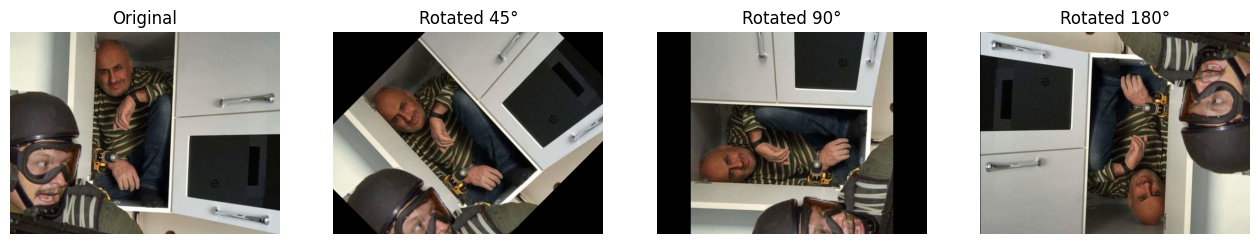

In [ ]:
display_rotated_images(img1, img1_rotated_45, img1_rotated_90, img1_rotated_180)

Сохраним картинки:

In [ ]:
def output_results(img, *rotated_imgs):
    angles = [45, 90, 180]

    # HOG:
    hog_original = hog(img)
    hog_rotated = [hog(rot_img) for rot_img in rotated_imgs]

    # HOG, модифицированный:
    hog_inv_original = hog_invariant(img)
    hog_inv_rotated = [hog_invariant(rot_img) for rot_img in rotated_imgs]

    # Расстояния для HOG:
    l1_default, l2_default = [], []
    for hog_rot in hog_rotated:
        l1, l2 = calculate_distances(hog_original, hog_rot)
        l1_default.append(l1)
        l2_default.append(l2)

    # Расстояния для инвариантного HOG:
    l1_inv, l2_inv = [], []
    for hog_inv_rot in hog_inv_rotated:
        l1, l2 = calculate_distances(hog_inv_original, hog_inv_rot)
        l1_inv.append(l1)
        l2_inv.append(l2)

    # Вывод результатов для стандартного HOG:
    print('Default HOG:')
    for i, angle in enumerate(angles):
        print(f"L1 между исходным и {angle}°: {l1_default[i]}")
        print(f"L2 между исходным и {angle}°: {l2_default[i]}")

    # Вывод результатов для инвариантного HOG:
    print('Invariant HOG:')
    for i, angle in enumerate(angles):
        print(f"L1 между исходным и {angle}°: {l1_inv[i]}")
        print(f"L2 между исходным и {angle}°: {l2_inv[i]}")

In [ ]:
output_results(img1, img1_rotated_45, img1_rotated_90, img1_rotated_180)

Default HOG:
L1 между исходным и 45°: 21989.29456187876
L2 между исходным и 45°: 111.59231094306149
L1 между исходным и 90°: 22244.72350899066
L2 между исходным и 90°: 112.44139858051197
L1 между исходным и 180°: 22559.777271493396
L2 между исходным и 180°: 111.72176951987942
Invariant HOG:
L1 между исходным и 45°: 3063.394775390625
L2 между исходным и 45°: 16.630252838134766
L1 между исходным и 90°: 2726.83740234375
L2 между исходным и 90°: 20.08694076538086
L1 между исходным и 180°: 126.3416748046875
L2 между исходным и 180°: 1.4197958707809448


**Пример 2:**

In [ ]:
!wget https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcQ9CloWDOwsfujsrCYHglNnkaHafvqrB3Nyv87D_jCWtF2aCIoP -O cat.jpg

--2024-11-30 13:49:54--  https://encrypted-tbn2.gstatic.com/images?q=tbn:ANd9GcQ9CloWDOwsfujsrCYHglNnkaHafvqrB3Nyv87D_jCWtF2aCIoP
Resolving encrypted-tbn2.gstatic.com (encrypted-tbn2.gstatic.com)... 142.250.152.139, 142.250.152.113, 142.250.152.101, ...
Connecting to encrypted-tbn2.gstatic.com (encrypted-tbn2.gstatic.com)|142.250.152.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3277 (3.2K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]   3.20K  --.-KB/s    in 0s      

2024-11-30 13:49:54 (43.6 MB/s) - ‘cat.jpg’ saved [3277/3277]



In [ ]:
img2 = cv2.imread("cat.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

In [ ]:
img2_rotated_45 = rotate_img(img2, 45)
img2_rotated_90 = rotate_img(img2, 90)
img2_rotated_180 = rotate_img(img2, 180)

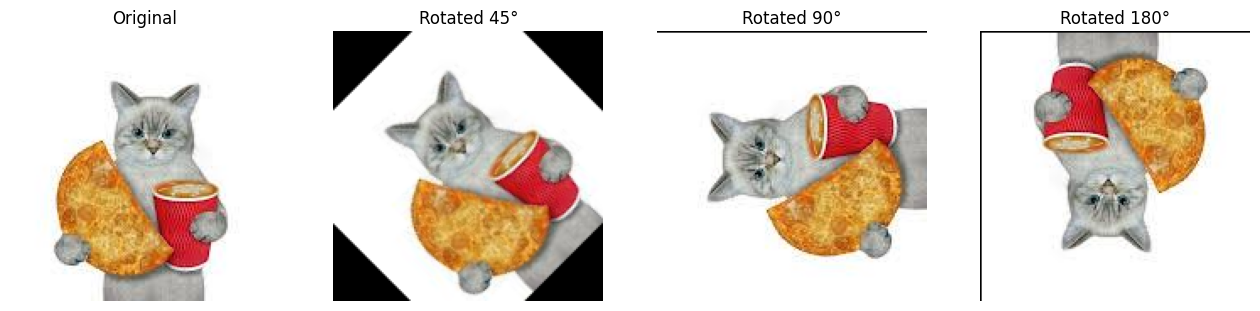

In [ ]:
display_rotated_images(img2, img2_rotated_45, img2_rotated_90, img2_rotated_180)

In [ ]:
output_results(img2, img2_rotated_45, img2_rotated_90, img2_rotated_180)

Default HOG:
L1 между исходным и 45°: 1116.4511412280062
L2 между исходным и 45°: 24.52362739072504
L1 между исходным и 90°: 1262.3014233338995
L2 между исходным и 90°: 26.33689017930765
L1 между исходным и 180°: 1376.2001873534823
L2 между исходным и 180°: 27.751161454021084
Invariant HOG:
L1 между исходным и 45°: 123.45626831054688
L2 между исходным и 45°: 3.0599918365478516
L1 между исходным и 90°: 6.524777412414551
L2 между исходным и 90°: 0.3212769329547882
L1 между исходным и 180°: 11.36102294921875
L2 между исходным и 180°: 0.5917674899101257


**Пример 3:**

In [ ]:
!wget https://banana.by/uploads/posts/2021-11/1637731842_banana.by-corgies-00008.jpg -O dog.jpg

--2024-11-30 13:49:56--  https://banana.by/uploads/posts/2021-11/1637731842_banana.by-corgies-00008.jpg
Resolving banana.by (banana.by)... 31.24.92.43
Connecting to banana.by (banana.by)|31.24.92.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147961 (144K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 144.49K   176KB/s    in 0.8s    

2024-11-30 13:49:58 (176 KB/s) - ‘dog.jpg’ saved [147961/147961]



In [ ]:
img3 = cv2.imread("dog.jpg")
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

In [ ]:
img3_rotated_45 = rotate_img(img3, 45)
img3_rotated_90 = rotate_img(img3, 90)
img3_rotated_180 = rotate_img(img3, 180)

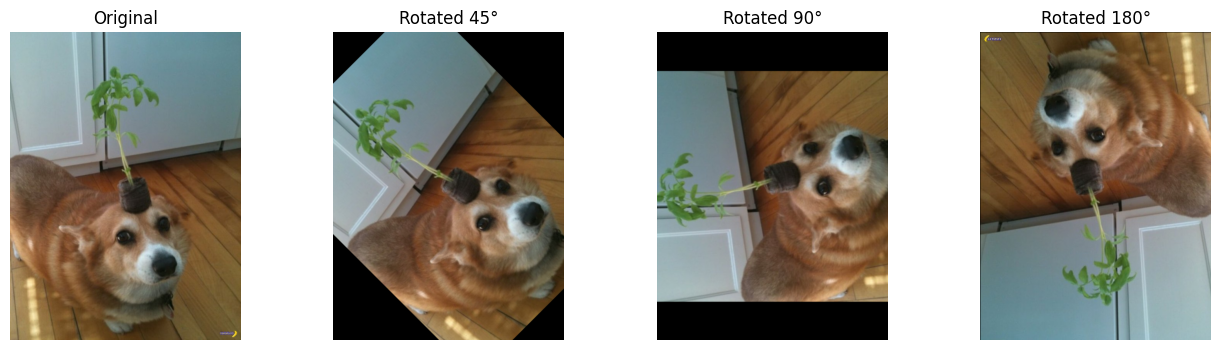

In [ ]:
display_rotated_images(img3, img3_rotated_45, img3_rotated_90, img3_rotated_180)

In [ ]:
output_results(img3, img3_rotated_45, img3_rotated_90, img3_rotated_180)

Default HOG:
L1 между исходным и 45°: 35844.182665350265
L2 между исходным и 45°: 141.7610180977032
L1 между исходным и 90°: 35524.52051079397
L2 между исходным и 90°: 141.5971762484073
L1 между исходным и 180°: 36672.62618949992
L2 между исходным и 180°: 142.48649012811185
Invariant HOG:
L1 между исходным и 45°: 5129.42724609375
L2 между исходным и 45°: 21.498016357421875
L1 между исходным и 90°: 6510.72021484375
L2 между исходным и 90°: 27.525177001953125
L1 между исходным и 180°: 184.49649047851562
L2 между исходным и 180°: 1.762961745262146


Вывод: при вычислении L1 и L2 между дескрипторами исходной и повернутой версий изображения видим, что в каждом из трех примеров значения L1 и L2 при использовании инвариантного HOG меньше, чем при использовании дефолтного HOG.